# **Hotel Cancel Culture** - **EDA Notebook**

---

**Author:** Ben McCarty

**Extension of Capstone Project** - Expanding Hotel Reservation dataset analysis and modeling

**Contact:** bmccarty505@gmail.com

---

## Revisiting the Reservations

---

Originally, I used this notebook to perform EDA with the intention of using the dataset only for classifying whether a reservation would cancel.

Now, as part of my efforts to revisit and revamp this overall repository and workflow, I am adapting it for broader uses, such as regression modeling and time series forecasting.

The end goal is to have a comprehensive overview of the data and to be flexible enough to handle different workflows.

**Warning: Work-in-Progress**

As this is a revamp of the original workbook, some of the code and comments may be outdated. I intend to update and clarify all steps in time, but there may be some parts that are out of place while I clean things up.

---

**Of Demand and Cancellations**

*This was the initial intro to the notebook with a focus on classification modeling.*

>**Every aspect of hospitality depends on accurately anticipating business demand**: how many rooms to clean; how many rooms are available to sell; what would be the best rate; and how to bring it all together to make every guest satisfied. 
>
> Proper forecasting is critical to every department and staff member, and to generate our forecasts, **hotel managers need to know how many guests will cancel prior to arrival**. Using data from two European hotels, I developed a model to predict whether a given reservation would cancel based on 30 different reservation details.

**In order to develop and train my models, I need to prepare the data in advance.**

>In this notebook, I explore the original dataset and its features; condense several features into smaller subsets; engineer new features; and remove unwanted features from the data.
>
**Once the data is prepared, I will reload the data in a new notebook to create and train my models to determine my predictions of who will stay and who will cancel.**

# **Import Packages**

In [1]:
## Used to re-import custom functions during development
%load_ext autoreload
%autoreload 2

In [2]:
## Enabling access to custom functions in separate directory

# Import necessary modules
import os
import sys

# Construct the absolute path to the 'src' directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Append the path to 'sys.path'
if src_path not in sys.path:
    sys.path.append(src_path)

import db_utils, eda

## Data Handling
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from missingno import matrix
import plotly.express as px
import seaborn as sns

In [3]:
## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
%matplotlib inline

# Read Source Data (with UUIDs)

In [4]:
# # Path to the DuckDB database file
# db_path = '../data/hotel_reservations.duckdb'

# ## Select subset of data for review
# q = 'SELECT * FROM res_data LIMIT 5'

# with db_utils.duckdb_connection(db_path) as conn:
#     data = conn.execute(q).df()
    
# data.head()

In [5]:
backup_data_path = '../data/data_condensed_with_uuid.parquet'

data = pd.read_parquet(backup_data_path)

data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber,UUID
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,8ca998d6-fae7-4ee4-a706-3765721aaff5
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,dd6424ee-6838-4007-ad85-de9ff96be14b
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,50ff56ee-6a72-40dc-8ff1-4246b831c779


## Add Pre-Engineered Date Features

In [6]:
filepath = '../data/engineered_data_dates.parquet'

df_dates = pd.read_parquet(filepath)
df_dates.head()

,UUID,ReservationStatusDate,ArrivalDate,DepartureDate,BookingDate,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,8ca998d6-fae7-4ee4-a706-3765721aaff5,2015-07-01,2015-07-01,2015-07-01,2014-07-24,45,21,45,21,22,44,27,3,27,3,30,4
1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,2015-07-01,2015-07-01,2015-07-01,2013-06-24,45,21,45,21,52,14,27,3,27,3,26,1
2,9429383d-0efd-4c37-bb9b-0aaa63d5aade,2015-07-02,2015-07-01,2015-07-02,2015-06-24,45,21,44,22,52,14,27,3,27,4,26,3
3,dd6424ee-6838-4007-ad85-de9ff96be14b,2015-07-02,2015-07-01,2015-07-02,2015-06-18,45,21,44,22,58,8,27,3,27,4,25,4
4,50ff56ee-6a72-40dc-8ff1-4246b831c779,2015-07-03,2015-07-01,2015-07-03,2015-06-17,45,21,43,23,59,7,27,3,27,5,25,3


In [7]:
df_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   UUID                             119390 non-null  object        
 1   ReservationStatusDate            119390 non-null  datetime64[ns]
 2   ArrivalDate                      119390 non-null  datetime64[ns]
 3   DepartureDate                    119390 non-null  datetime64[ns]
 4   BookingDate                      119390 non-null  datetime64[ns]
 5   ArrivalDate_DaysBeforeHoliday    119390 non-null  int64         
 6   ArrivalDate_DaysAfterHoliday     119390 non-null  int64         
 7   DepartureDate_DaysBeforeHoliday  119390 non-null  int64         
 8   DepartureDate_DaysAfterHoliday   119390 non-null  int64         
 9   BookingDate_DaysBeforeHoliday    119390 non-null  int64         
 10  BookingDate_DaysAfterHoliday     119390 non-

## Condense to Single DataFrame

In [8]:
data = data.merge(right = df_dates, how = 'left', on = 'UUID')
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate_x,HotelNumber,UUID,ReservationStatusDate_y,ArrivalDate,DepartureDate,BookingDate,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,8ca998d6-fae7-4ee4-a706-3765721aaff5,2015-07-01,2015-07-01,2015-07-01,2014-07-24,45,21,45,21,22,44,27,3,27,3,30,4
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,2015-07-01,2015-07-01,2015-07-01,2013-06-24,45,21,45,21,52,14,27,3,27,3,26,1
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade,2015-07-02,2015-07-01,2015-07-02,2015-06-24,45,21,44,22,52,14,27,3,27,4,26,3
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,dd6424ee-6838-4007-ad85-de9ff96be14b,2015-07-02,2015-07-01,2015-07-02,2015-06-18,45,21,44,22,58,8,27,3,27,4,25,4
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,50ff56ee-6a72-40dc-8ff1-4246b831c779,2015-07-03,2015-07-01,2015-07-03,2015-06-17,45,21,43,23,59,7,27,3,27,5,25,3


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IsCanceled                       119390 non-null  int64         
 1   LeadTime                         119390 non-null  int64         
 2   ArrivalDateYear                  119390 non-null  int64         
 3   ArrivalDateMonth                 119390 non-null  object        
 4   ArrivalDateWeekNumber            119390 non-null  int64         
 5   ArrivalDateDayOfMonth            119390 non-null  int64         
 6   StaysInWeekendNights             119390 non-null  int64         
 7   StaysInWeekNights                119390 non-null  int64         
 8   Adults                           119390 non-null  int64         
 9   Children                         119386 non-null  float64       
 10  Babies                           119390 non-

## Dropping Old Features

*Some features were used to engineer new features - particularly arrival details.*

In [10]:
drop_feats = list(data.columns)[1:8]
drop_feats.append(list(data.columns)[30])
drop_feats.extend(list(data.columns)[33:37])
drop_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'ReservationStatusDate_x',
 'ReservationStatusDate_y',
 'ArrivalDate',
 'DepartureDate',
 'BookingDate']

In [11]:
data = data.drop(columns = drop_feats)
data.head()

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,HotelNumber,UUID,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,1,8ca998d6-fae7-4ee4-a706-3765721aaff5,45,21,45,21,22,44,27,3,27,3,30,4
1,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,45,21,45,21,52,14,27,3,27,3,26,1
2,0,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade,45,21,44,22,52,14,27,3,27,4,26,3
3,0,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,1,dd6424ee-6838-4007-ad85-de9ff96be14b,45,21,44,22,58,8,27,3,27,4,25,4
4,0,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,1,50ff56ee-6a72-40dc-8ff1-4246b831c779,45,21,43,23,59,7,27,3,27,5,25,3


# Abbreviated EDA

---

- Original notebook reviewed each feature in depth
- Abbreviating review for simplicity.

---

## Summary Stats via Describe Method

In [12]:
## Numeric Stats
data.describe(include = 'number', )

,IsCanceled,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,HotelNumber,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
count,"119,390.00","119,390.00","119,386.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00"
mean,0.37,1.86,0.10,0.01,0.03,0.09,0.14,0.22,2.32,101.83,0.06,0.57,1.66,30.91,30.95,31.66,30.24,36.70,31.97,26.76,4.00,26.81,4.21,24.77,3.60
std,0.48,0.58,0.40,0.10,0.18,0.84,1.50,0.65,17.59,50.54,0.25,0.79,0.47,26.21,26.54,26.51,26.24,28.27,26.41,13.57,1.95,13.59,2.06,16.30,1.84
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-6.38,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,69.29,0.00,0.00,1.00,9.00,9.00,10.00,8.00,12.00,10.00,16.00,2.00,16.00,2.00,9.00,2.00
50%,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,94.58,0.00,0.00,2.00,24.00,24.00,24.00,23.00,31.00,25.00,27.00,4.00,27.00,4.00,25.00,4.00
75%,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00,2.00,46.00,48.00,47.00,47.00,55.00,49.00,38.00,6.00,38.00,6.00,40.00,5.00
max,1.00,55.00,10.00,10.00,1.00,26.00,72.00,21.00,391.00,"5,400.00",8.00,5.00,2.00,115.00,114.00,115.00,114.00,115.00,114.00,53.00,7.00,53.00,7.00,53.00,7.00


---

- Outliers present in many features
- Outlier detection/removal may be required in preprocessing pipeline for certain model types

---

In [13]:
## Non-Numeric Stats
data.describe(exclude = 'number')

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,UUID
count,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,5,177,8,5,10,12,3,334,353,4,3,119390
top,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Check-Out,8ca998d6-fae7-4ee4-a706-3765721aaff5
freq,92310,48590,56477,97870,85994,74053,104641,31961,112593,89613,75166,1


---

- High cardinality in Country, Agent, Company (disregard UUID; reservation ID)

---

## Missing Values

In [14]:
nan_sum = data.isna().sum()
nan_sum[nan_sum>0]

Children      4
Country     488
dtype: int64

In [15]:
nan_avg = data.isna().mean()
nan_avg[nan_avg>0]

Children   0.00
Country    0.00
dtype: float64

---

- Two features missing values
- Average number of missing values less than 1%
- No action taken; will address in model pipeline

---

## Visualizing Data

In [16]:
data_number = data.select_dtypes(include = 'number').columns
data_non_num = data.select_dtypes(exclude = 'number').columns

### Numeric

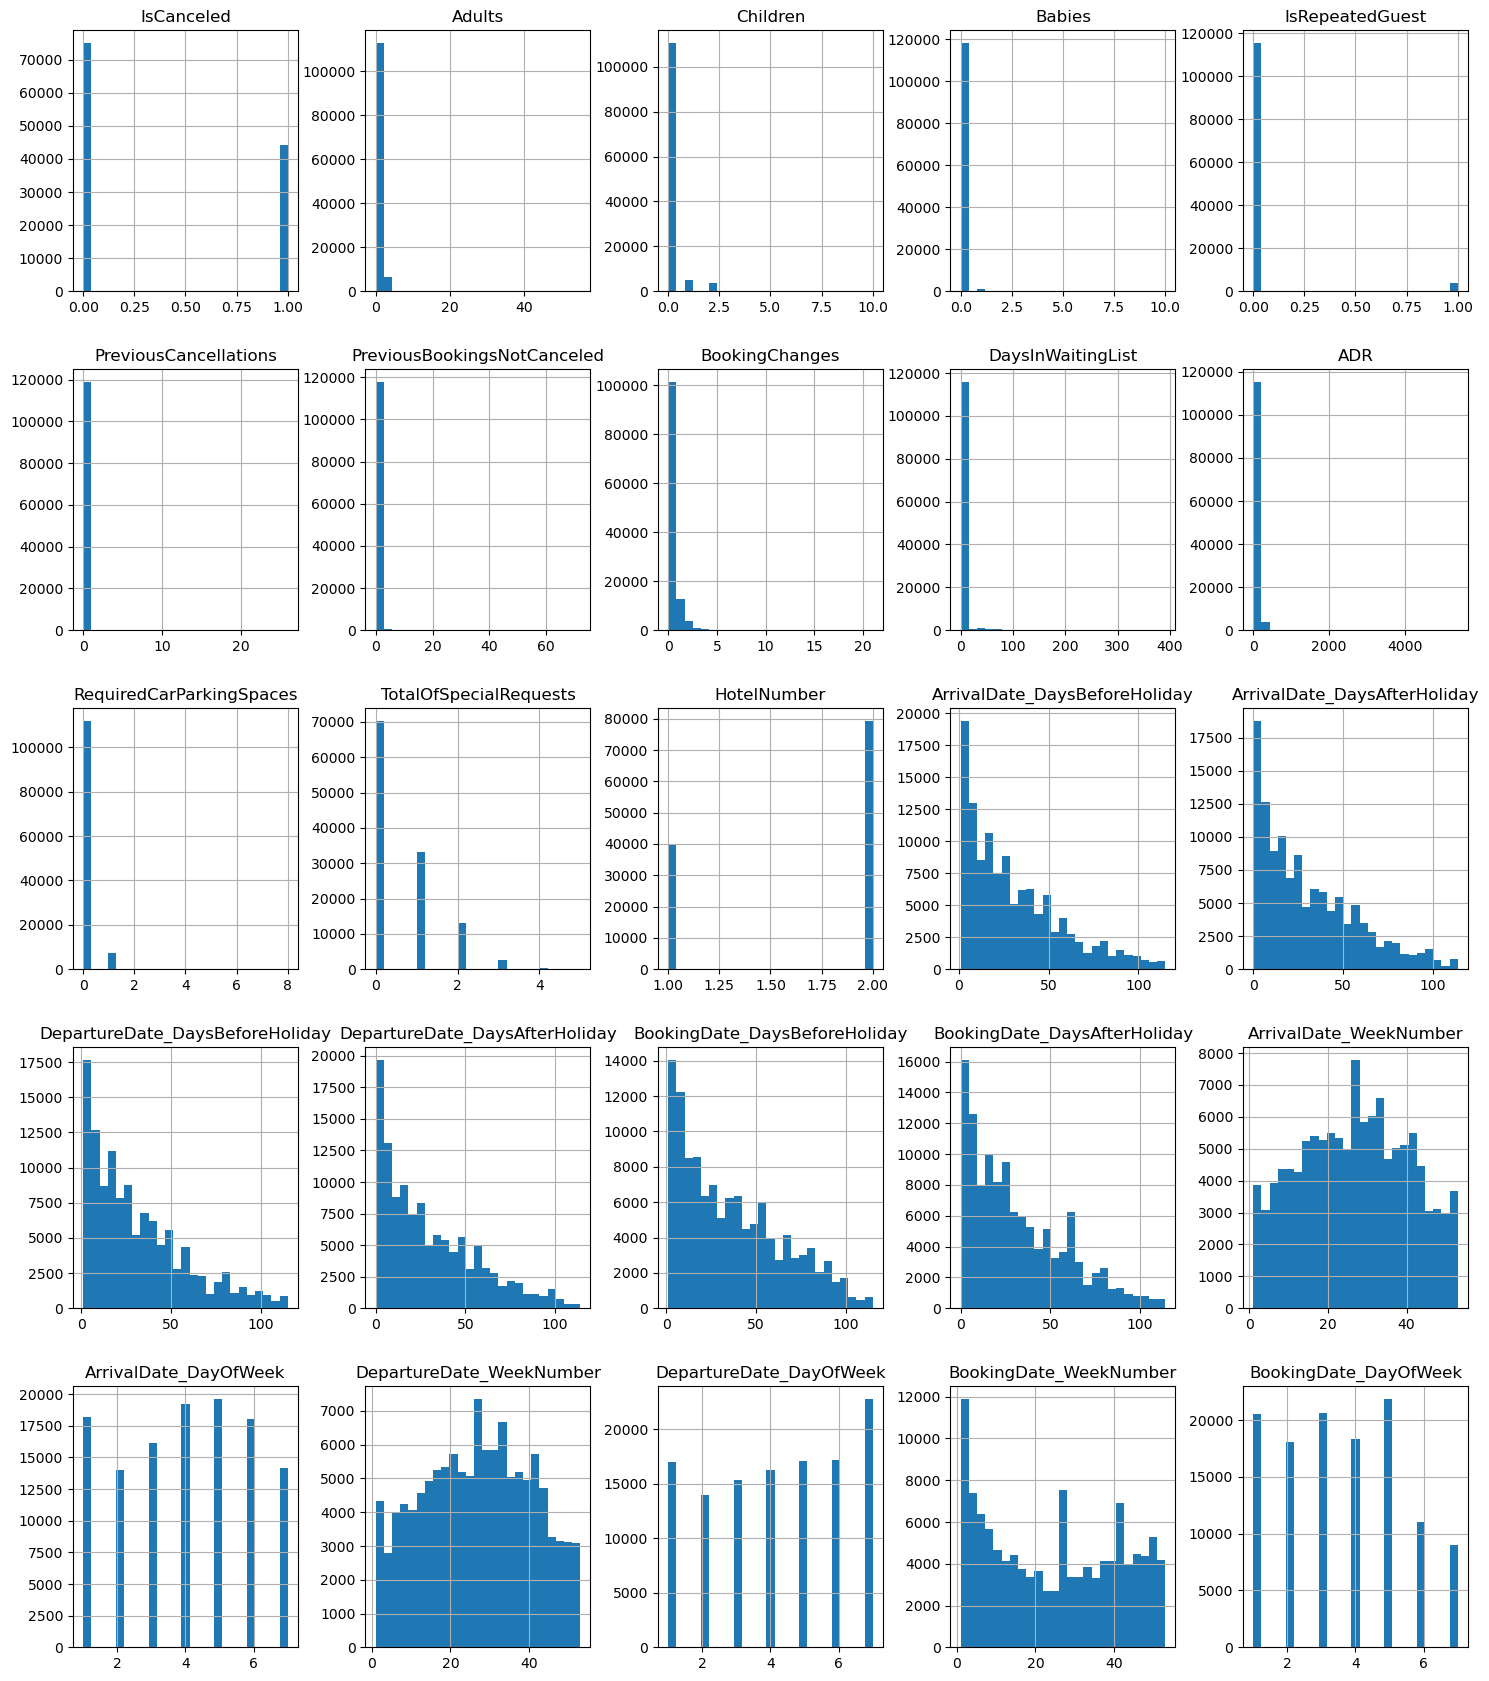

In [30]:
data[data_number].hist(bins = 25, figsize = (18,21), layout = (-1, 5));

### Non-Numeric

In [34]:
data[data_non_num].drop(columns = ['UUID']).describe().T

,count,unique,top,freq
Meal,119390,5,BB,92310
Country,118902,177,PRT,48590
MarketSegment,119390,8,Online TA,56477
DistributionChannel,119390,5,TA/TO,97870
ReservedRoomType,119390,10,A,85994
AssignedRoomType,119390,12,A,74053
DepositType,119390,3,No Deposit,104641
Agent,119390,334,9,31961
Company,119390,353,NULL,112593
CustomerType,119390,4,Transient,89613


In [ ]:
data[data_non_num].value_counts().plot(kind = 'bar')


KeyboardInterrupt



#  **Post-EDA Updates**

---

**Feature Changes and Engineering**

> After reviewing all of the features and their statistics, I noticed a few things needed to change. 

**These Changes Include:**
>* Condensing specific features
* Engineering new features
* Dropping duplicated/unnecessary features

---

## Condensing Features

### Condensing `Meal`

---

> The feature reference dictionary states that the "undefined" values for `Meal` are part of the "SC" category. While there are a relatively small number of "undefined" entries, I feel that it would be most accurate to re-categorize them  to the "SC" Meal type.

---

In [ ]:
## Inspecting normalized value counts
data['Meal'].value_counts()

In [ ]:
## Testing normalized value counts after replacement
data['Meal'].replace('Undefined', 'SC').value_counts(1)

In [ ]:
## Performing replacement and verifying results
data['Meal'] = data['Meal'].replace('Undefined', 'SC')
data['Meal'].value_counts(1)

In [ ]:
## Reviewing new details for Meal
eda.explore_feature(data,'Meal',target_feature = 'IsCanceled', plot_label ='Meal Type',plot_title= 'Meals',
                    show_visualization = show_visualization);

---

> After these changes, I have four distinct categories with the "undefined" Meal types added to the "SC" Meal types. Now I will perform a larger condensation with the `Agent` feature.

---

### Condensing `Agent` into `Agent_Group`

---

**This feature requires a more complex approach than the `Meal` feature.**

> `Agent` includes a large number of unique values (each unique value being a unique identifier for an Agent). To use this feature in modeling, I would need to perform one-hot encoding, resulting in an additional 300+ features for all of my reservations. I will explore two main questions to determine how to handle this feature:
1. What are the top ten IDs by percentages?
2. Is there a way to condense this feature into a smaller set of categories?

**Depending on the breakdown of percentages, I would like to condense this feature to a smaller number of unique values.**

> Condensing the features would result in fewer additional columns post-encoding as well as potentially increasing the impact of this feature. **However, it would impair the interpretability of the results;** if my model's results show that the condensed value is significant, it would mean that the *combination of all of the values* is significant, not any particular one Agent.

**Despite the loss of interpretability, I feel it is best to condense these values.**

---

In [ ]:
## Confirming number of unique values
data['Agent'].nunique()

In [ ]:
## Reviewing top ten Agents by percentage of bookings
data['Agent'].value_counts(normalize=True, ascending=False,
                           dropna=False).iloc[:10]

In [ ]:
## Visualizing top ten Agents by percentage of bookings
top_Agents = data['Agent'].value_counts(normalize=True, ascending=True,
                                        dropna=False).iloc[-10:]

fig, ax = plt.subplots(figsize= (8, 4))
top_Agents.plot(kind='barh', ax=ax)

fig.suptitle('Top Ten Agents by Volume')
ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .05, .10, .15, .20, .25])
ax.set_xticklabels(['0', '5','10', '15', '20', '25'])
ax.set_ylabel("Agent ID")

for i,vc in enumerate(top_Agents):
    plt.text(x=vc+.0025, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

---

**Analysis shows there are three top Agents, representing a combined total of nearly half of the total reservations.**

> Additionally, the 14% of missing values represents a significant proportion of the overall dataset. The remaining 41% percent of the data consists of the other Agents with 3% or less of the overall reservations.

**Based on these results, I feel comfortable in condensing the values into five distinct categories:** 
>* The top three Agent IDs (no changes)
* A placeholder ('0') to indicate the lack of an ID
* A placeholder ('999') representing the combination of all of the lower-production Agents

**I will replace the values and inspect the breakdown of the resulting data.**

---

In [ ]:
## Reviewing number of missing values
data['Agent'].isna().sum()

In [ ]:
## Filling with placeholder value and confirming results
data['Agent'] = data['Agent'].fillna(0.00)
data['Agent'].isna().sum()

In [ ]:
## Converting non-top-3 ID values to placeholder "999"
cond = [data['Agent'] == 9.00,
        data['Agent'] == 240.00,
        data['Agent'] == 1.00,
        data['Agent'] == 0.00
       ]

choice = [data['Agent'], data['Agent'], data['Agent'], data['Agent']]

data['Agent_group'] = np.select(cond, choice, 999)
data[['Agent', 'Agent_group']]

In [ ]:
## Converting column to string

data.loc[:,'Agent_group'] = data.loc[:,'Agent_group'].astype(int)
data.loc[:,'Agent_group'] = data.loc[:,'Agent_group'].astype(str)
print(f'Datatype: {data["Agent_group"].dtype}')

In [ ]:
## Creating new Series for visualization
new_cats = data['Agent_group'].value_counts(1, ascending=True)
new_cats

In [ ]:
##Visualizing new feature

fig, ax = plt.subplots(figsize= (8, 4))
new_cats.plot(kind='barh', ax=ax)

fig.suptitle('Agent - New Categories')

ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .1, .2, .3, .4, .5])
ax.set_xticklabels(['0', '10','20', '30', '40', '50'])
ax.set_ylabel("Agent ID")

for i,vc in enumerate(new_cats):
    plt.text(x=vc+.005, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

In [ ]:
# Dropping "Agent" feature after conversion
data.drop(columns = ['Agent'], inplace=True)
data.columns

In [ ]:
## Confirming 'Agent' removal from dataframe
'Agent' not in data

In [ ]:
## Deleting variables to free up space
del cond, choice, new_cats

---

**After converting the values, there are now five unique values instead of 333.**

> The resulting values represent the top three Agents by production percentage; the percentage of reservations not associated with an Agent (missing values prior to conversion); and then the combined percentage of Agents producing 3% or less of the overall reservations.
>
> This condensation balances my desire to simplify this category; the need to address missing values; and my intention to maintain the value of all of the Agent IDs.

**Now I will condense the `Country` category in a similar manner.**

---

### Condensing `Country` Categories

---

> The `Country` feature includes 177 unique Country names, but 5 countries compose about 73% of all of the values. To reduce the complexity of this feature and to increase the value of the remaining distinct countries, I will condense these features as I did for the `Agent` feature.

---

In [ ]:
## Confirming number of unique values
data['Country'].nunique()

In [ ]:
## Reviewing top ten Agents by percentage of bookings
data['Country'].value_counts(normalize=True, ascending=False, dropna=False).iloc[:10]

In [ ]:
## Visualizing top ten countries by percentage of bookings
top_countries = data['Country'].value_counts(normalize=True, ascending=True,
                                        dropna=False).iloc[-10:]

fig, ax = plt.subplots(figsize= (8, 4))
top_countries.plot(kind='barh', ax=ax)

fig.suptitle('Top Ten Countries by Volume')
ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .05, .10, .15, .20, .25, .30, .35, .40])
ax.set_xticklabels(['0', '5','10', '15', '20', '25', '30', '35', '40'])
ax.set_ylabel("Country ID")
ax.axhline(y=4.5, ls = ":", c='k', label = "5%")
ax.legend(labels = ['5% Threshold', 'Volume (%)'])

for i,vc in enumerate(top_countries):
    plt.text(x=vc+.0025, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

---

**Analysis shows there are five countries composing over 5% of the reservations, representing a combined total of nearly 73% of the total reservations.**

> These countries represent more than 5% of the overall feature values, with the remaining 27% below 5%.

**Based on these results, I feel comfortable in condensing the values into six distinct categories:** 
>* The top five Country IDs (no changes)
* A placeholder ('Other') representing the combination of all of the lower-production countries

**I will replace the values and inspect the breakdown of the resulting data.**

---

In [ ]:
## Converting non-top-3 ID values to placeholder "999"
cond = [data['Country'] == 'PRT',
        data['Country'] == 'GBR',
        data['Country'] == 'FRA',
        data['Country'] == 'ESP',
        data['Country'] == 'DEU'
       ]

choice = [data['Country'], data['Country'], data['Country'], data['Country'],
          data['Country']]

data['Country'] = np.select(cond, choice, 'Other')
data['Country']

In [ ]:
## Creating new Series for visualization
new_cats = data['Country'].value_counts(1, ascending=True)
new_cats

In [ ]:
##Visualizing new feature

fig, ax = plt.subplots(figsize= (8, 4))
new_cats.plot(kind='barh', ax=ax)

fig.suptitle('Country - Updated Categories')

ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .1, .2, .3, .4, .5])
ax.set_xticklabels(['0', '10','20', '30', '40', '50'])
ax.set_ylabel("Country ID")

for i,vc in enumerate(new_cats):
    plt.text(x=vc+.005, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

In [ ]:
## Deleting variables to free up space
del cond, choice, new_cats

## Feature Engineering

---

> Now that I condensed my existing features, I will create two new ones:
* `arrival_date`: representing the date the reservation is expected to check-in; useful for future forecasting
* `stay_length`: for how many nights a guest will stay
>
> This information is standard for all hotels and will be helpful for modeling (and later forecasting).

---

### Engineering `Arrival_Date`

In [ ]:
## Converting from month, day of month, and year to a single datetime column
data['arrival_date'] = data['ArrivalDateMonth'] +' '+ \
                                data['ArrivalDateDayOfMonth']\
                                .astype(str) +', '+ \
                                data['ArrivalDateYear'].astype(str)
data['arrival_date'] = pd.to_datetime(data['arrival_date'])
data['arrival_date']

In [ ]:
## Determining the day of the week of arrival 
data.loc[:,'arrival_day'] = data.loc[:,'arrival_date'].dt.day_name()
data['arrival_day']

In [ ]:
## Reviewing results
data[['arrival_day', 'arrival_date']]

In [ ]:
## Reviewing details for arrival_day
eda.explore_feature(data,'arrival_day',target_feature = 'IsCanceled', 
plot_label ='Day',
                    plot_title= 'Arrival Day',
                    show_visualization = show_visualization);

---

**Feature Review**

> This new feature gives a more precise representation of when a reservation is expected to arrive. Having an idea of anticipated occupancy by day is critical for operations for daily cleaning, staffing, etc..

---

### Engineering `Stay Length`

---

> One major feature of a guest's reservation is missing from the original dataset: the overall stay length. I feel a reservation's stay length is relevant to my analysis, and so I will engineer this feature by adding the number of week day and weekend nights together.

---

In [ ]:
## Creating stay_length as a summation of weekday and weekend night counts
data['stay_length'] = data['StaysInWeekendNights'] + data['StaysInWeekNights']
data['stay_length'].value_counts(dropna=False)

In [ ]:
## Reviewing details for stay_length
eda.explore_feature(data,'stay_length',target_feature = 'IsCanceled', plot_label ='Length',
                    plot_title= 'Length of Stay', bins=10,
                    show_visualization = show_visualization);

---

**Feature Review**

> Both checkouts and cancellations show that most guests are staying for less than a week, which is understandable for standard hotels and resorts (there are exceptions, such as brands oriented towards long-term stays of 7+ days).

---

## Dropping Features

---

> During the EDA process, I noted several features were less useful than others and would need to be dropped from the dataset. I will drop the following features/rows:
* `market_segment`, `"undefined"` value: represented less than 1% of reservations
* `distribution_channel`: too similar to `market_segment`
* `reservation_status`: too similar to target feature
* `arrival_date_year`: specific to reservations in dataset; not usable for future reservations
* `reservation_status_date`: does not add substantial information

---

### Dropping "Undefined" from `Market_Segment`

---

> There are less than 1% of reservations with an "undefined" market segment. To reduce the future number of features post-one-hot-encoding, I will remove these features.

---

In [ ]:
## Confirming low number of "undefined" values in market_segment
data['MarketSegment'].value_counts()

In [ ]:
## Inspecting reservations listed as "undefined"
data[data['MarketSegment'] == 'Undefined']

In [ ]:
## Removing those reservations from the dataset
data = data[data['MarketSegment'] != 'Undefined']
data

### Comparing `Market_Segment` and `Distribution_Channel`

---

**What's the difference?**

>Based on my personal career experience, I know that these two features represent nearly the same information.
* ***Market segments*** represent customers with distinct needs, behaviors, and may have additional distinguishing characteristics (groups, contracts, and businesses).
* ***Distribution channels*** are the means by which these reservations are booked and processed, often overlapping with the guest segmentation.

**Which to keep?**

> **As the two values demonstrate high multicollinearity, I will keep the feature providing the most diverse insights.** I will inspect the values for each feature and keep whichever feature adds the most diverse insights. I will drop the other feature.

---

In [ ]:
## Inspecting breakdowns
print('Distribution Channel:\n',data['DistributionChannel'].value_counts(1),
      '\n\n')
print('Market Segment:\n',data['MarketSegment'].value_counts(1))

---

**While both features describe similar information, `market_segment` includes more distinct information.** I will keep `market_segment` and drop `distribution_channel`.

---

In [ ]:
## Dropping "distribution_channel"
data = data.drop(columns = 'DistributionChannel')

In [ ]:
## Confirming 'distribution_channel' removal from dataframe
'DistributionChannel' not in data

### Dropping `Reservation_Status`

---

> `Reservation_Status` is nearly identical to my target feature and would be too strong of a predictor in my models.

---

In [ ]:
## Dropping "reservation_status"
data.drop(columns = 'ReservationStatus', inplace=True)

In [ ]:
## Confirming 'reservation_status' removal from dataframe
'ReservationStatus' not in data

### Dropping `Arrival_Date_Year`

---

> `Arrival_Date_Year` would not be applicable to future models; it would impair model performance when the model is given data for new years.

---

In [ ]:
## Dropping "arrival_date_year"
data.drop(columns = 'ArrivalDateYear', inplace=True)

In [ ]:
## Confirming 'arrival_date_year' removal from dataframe
'ArrivalDateYear' not in data

### Dropping `Reservation_Status_Date`

In [ ]:
## Dropping "reservation_status_date"
data.drop(columns = 'ReservationStatusDate', inplace=True)

In [ ]:
## Confirming 'reservation_status_date' removal from dataframe
'ReservationStatusDate' not in data

## Final Data Review

---

> Now that I completed my condensation, engineering, and dropping of features, I will review the final data prior to saving the results for modeling.

---

In [ ]:
## Inspecting final dataframe
data

# Preserving the Pandas (DataFrame)

---

Now I am ready to save the cleaned and processed data for modeling in my next notebook.

---

In [ ]:
# ## Pickling with Pandas
# data.to_pickle(path = '../data/data_prepped.pickle',
#             compression = 'gzip')
# print(f'Successfully pickled!')

In [ ]:
## Pickling with Pandas
data.to_parquet(path = '../data/data_prepped.parquet')
print(f'Successfully saved!')

# Future Work: EDA

---

In the future, I will revisit the visualization aspects of my EDA function to convert them from Plotly Express figures to Matplotlib figures. The goal with Plotly Express was to have additional interativity; however these models crippled my notebook's operations. Matplotlib figures would be more appropriate in this case, and I will revisit this work when I have more time.

---


# Moving to Modeling!

---

> Now that I completed the pre-processing and EDA steps, I will move to my next notebook to perform my classification modeling.

---